Biblioteki

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

Ścieżki i wstępne ustawienia

In [12]:
edge_count_list = ['4', '5', '6', '7']
data_dir_model = 'graphs_all'
train_dir = os.path.join(data_dir_model, 'train')
validation_dir = os.path.join(data_dir_model, 'validation')

# Sprawdź, czy katalogi istnieją, jeśli nie, stwórz je
for directory in [data_dir_model, train_dir, validation_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        # Jeśli katalog nie jest pusty, wyczyść go
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path): 
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Nie udało się usunąć {file_path}. Powód: {e}')

In [13]:
# Wielkość obrazów i wielkość partii
img_height, img_width = 180, 180
batch_size = 32

In [14]:
for edge_count in edge_count_list:
    data_dir_generated = '../graph_generator/' + edge_count

    # Pobierz listę wszystkich katalogów z grafami
    all_images_catalogs = os.listdir(data_dir_generated)

    for catalog in all_images_catalogs:
        catalog_path = os.path.join(data_dir_generated, catalog)
        all_images = os.listdir(catalog_path)

        # Podziel listę obrazów na zestawy treningowe i walidacyjne
        train_images, validation_images = train_test_split(all_images, test_size=0.2, random_state=42)

        # Stwórz katalogi dla każdej klasy
        train_class_dir = os.path.join(train_dir, catalog)
        validation_class_dir = os.path.join(validation_dir, catalog)
        for directory in [train_class_dir, validation_class_dir]:
            if not os.path.exists(directory):
                os.makedirs(directory)

        # Kopiuj obrazy do odpowiednich katalogów
        for train_image in train_images:
            shutil.copy(os.path.join(catalog_path, train_image), os.path.join(train_class_dir, train_image))

        for validation_image in validation_images:
            shutil.copy(os.path.join(catalog_path, validation_image), os.path.join(validation_class_dir, validation_image))

Przenoszenie do katalogów

In [15]:
# Pobierz listę wszystkich katalogów z grafami
all_images_catalogs = os.listdir(data_dir_generated)

for catalog in all_images_catalogs:
    catalog_path = os.path.join(data_dir_generated, catalog)
    all_images = os.listdir(catalog_path)

    # Podziel listę obrazów na zestawy treningowe i walidacyjne
    train_images, validation_images = train_test_split(all_images, test_size=0.2, random_state=42)

    # Stwórz katalogi dla każdej klasy
    train_class_dir = os.path.join(train_dir, catalog)
    validation_class_dir = os.path.join(validation_dir, catalog)
    for directory in [train_class_dir, validation_class_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)
        else:
            # Jeśli katalog nie jest pusty, wyczyść go
            for file in os.listdir(directory):
                os.remove(os.path.join(directory, file))

    # Kopiuj obrazy do odpowiednich katalogów
    for train_image in train_images:
        shutil.copy(os.path.join(catalog_path, train_image), os.path.join(train_class_dir, train_image))

    for validation_image in validation_images:
        shutil.copy(os.path.join(catalog_path, validation_image), os.path.join(validation_class_dir, validation_image))

In [16]:
def rgb_to_grayscale(images):
    return tf.image.rgb_to_grayscale(images)

Model

In [17]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
history = []
all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir_model) for f in filenames if os.path.splitext(f)[1] == '.png']

for train_index, val_index in kfold.split(all_images):
  train_images = [all_images[i] for i in train_index]
  validation_images = [all_images[i] for i in val_index]

  # Generowanie danych treningowych
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  train_ds = train_ds.map(lambda x, y: (rgb_to_grayscale(x), y))

  # Generowanie danych walidacyjnych
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = val_ds.map(lambda x, y: (rgb_to_grayscale(x), y))

  # Tworzenie modelu
  model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
  ])
  
  # Kompilacja modelu
  model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
  )

  # Uczenie modelu
  history.append(model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75
  ))

Found 2000 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Epoch 1/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.2623 - loss: 2.5349 - val_accuracy: 0.8760 - val_loss: 0.8627
Epoch 2/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9159 - loss: 0.5401 - val_accuracy: 1.0000 - val_loss: 0.1880
Epoch 3/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.9904 - loss: 0.1880 - val_accuracy: 1.0000 - val_loss: 0.1143
Epoch 4/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9885 - loss: 0.1439 - val_accuracy: 1.0000 - val_loss: 0.1211
Epoch 5/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.9672 - loss: 0.2287 - val_accuracy: 0.9860 - val_loss: 0.3609
Epoch 6/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9729 - loss: 0.3424 - val_accuracy: 0.9980 - val_loss: 0.1553
Epoch 7/75
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.9898 - loss: 0.1512 - val_accuracy: 0.9980 - val_loss: 0.1020
Epoch 8/75
63/63 ━━━━

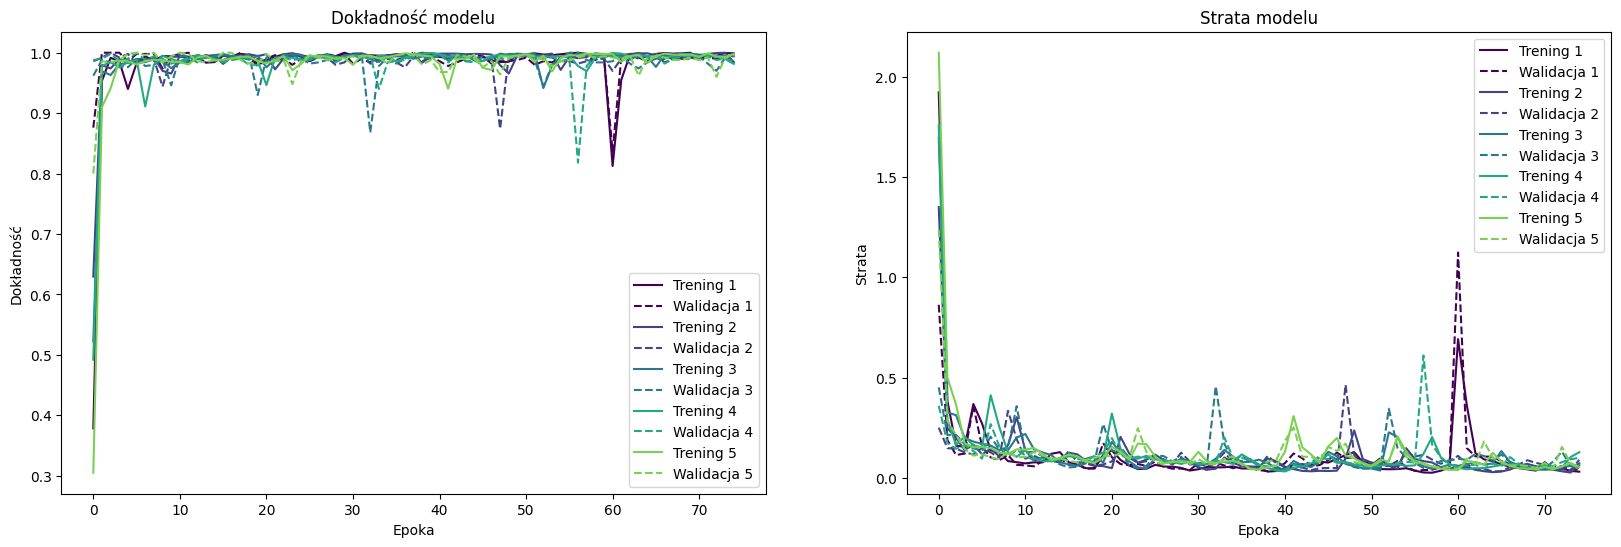

Średnia dokładność na zbiorze walidacyjnym: 99.16%


In [18]:
# Tworzymy figurę
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Dla każdego podziału
for i, h in enumerate(history):
    # Wybieramy kolor
    color = plt.cm.viridis(i / len(history))

    # Wykres dokładności
    ax1.plot(h.history['accuracy'], color=color, label='Trening {}'.format(i+1))
    ax1.plot(h.history['val_accuracy'], '--', color=color, label='Walidacja {}'.format(i+1))

    # Wykres straty
    ax2.plot(h.history['loss'], color=color, label='Trening {}'.format(i+1))
    ax2.plot(h.history['val_loss'], '--', color=color, label='Walidacja {}'.format(i+1))

# Ustawiamy tytuły i etykiety
ax1.set_title('Dokładność modelu')
ax1.set_ylabel('Dokładność')
ax1.set_xlabel('Epoka')
ax1.legend()

ax2.set_title('Strata modelu')
ax2.set_ylabel('Strata')
ax2.set_xlabel('Epoka')
ax2.legend()

# Wyświetlamy figurę
plt.show()

# Średnia dokładność na zbiorze walidacyjnym
average_accuracy = np.mean([h.history['val_accuracy'][-1] for h in history])
print("Średnia dokładność na zbiorze walidacyjnym: {:.2f}%".format(average_accuracy * 100))

In [22]:
def get_image_filenames(folder):
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"): # Add or modify to suit your image file types
            filenames.append(filename)
    return filenames

In [23]:
# Zmieniamy funkcję, aby przeszukiwała również podkatalogi
def get_image_filenames(directory):
    return [os.path.join(root, name)
            for root, dirs, files in os.walk(directory)
            for name in files
            if name.endswith((".png", ".jpg", ".jpeg"))]

# Ścieżka do obrazu, który chcesz przetestować
test_photo_path = 'test_graphs'

test_photos = get_image_filenames(test_photo_path)
test_photos

['test_graphs\\drawn\\connected-drawn-1.png',
 'test_graphs\\drawn\\cycle-drawn-1.png',
 'test_graphs\\drawn\\full-drawn-1.jpg',
 'test_graphs\\drawn\\full-drawn-2.jpg',
 'test_graphs\\drawn\\full-drawn-3.png',
 'test_graphs\\drawn\\path-drawn-1.png',
 'test_graphs\\drawn\\path-drawn-2.png',
 'test_graphs\\drawn\\path-drawn-3.png',
 'test_graphs\\generated\\cycle-45.png',
 'test_graphs\\generated\\full-113.png',
 'test_graphs\\generated\\path-78.png',
 'test_graphs\\internet\\internet-cycle-1.png',
 'test_graphs\\internet\\internet-full-1.jpg',
 'test_graphs\\internet\\internet-full-2.jpg']

In [24]:
for test_photo in test_photos:
    # Wybór obrazka testowego
    image_path = test_photo

    # Wczytanie obrazu i dostosowanie go do odpowiedniego rozmiaru
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Przekształć obraz do skali szarości
    img_array = rgb_to_grayscale(img_array)
    # Rozszerz wymiary obrazu
    img_array = tf.expand_dims(img_array, 0)

    # Przewidywanie klasy obrazu
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "|- {} -| najprawdopodobniej należy do klasy |- {} -| z prawdopodobieństwem {:.2f} procent."
        .format(test_photo, class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
|- test_graphs\drawn\connected-drawn-1.png -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 100.00 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
|- test_graphs\drawn\cycle-drawn-1.png -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 100.00 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
|- test_graphs\drawn\full-drawn-1.jpg -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 99.99 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
|- test_graphs\drawn\full-drawn-2.jpg -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 100.00 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
|- test_graphs\drawn\full-drawn-3.png -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 100.00 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
|- test_graphs\drawn\path-drawn-1.png -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 98.33 procent.
1/1 ━━━━━━━━━━━━━━